In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from itertools import combinations 

In [2]:
df = pd.read_pickle('2019.pkl.gz')

In [3]:
df.event_type_de.unique()
# 11 is an ejection
#df[df.event_type_de == 11]

array(['period-start', 'jump-ball', 'missed_shot', 'rebound', 'turnover',
       'shot', 'foul', 'team-timeout', 'substitution', 'free-throw',
       'period-end', 'goal-tending', 'instant-replay', 11], dtype=object)

In [4]:
possessions_og = []
minutes_og = []

p_counter = 1
s_counter = 0
hs_counter = 0
as_counter = 0
gameid = 'NONE'

for row in df.itertuples():
    if row[1] != gameid:
        p_counter = 1
        s_counter = 0
        hs_counter = 0
        as_counter = 0
        h_p_prev = sorted([row[i] for i in range(62,71,2)])
        a_p_prev = sorted([row[i] for i in range(72,82,2)])
        gameid = row[1]

    h_players = sorted([row[i] for i in range(62,71,2)])
    a_players = sorted([row[i] for i in range(72,82,2)])

    if 'Stephen Curry' in a_players and 'Damian Lillard' in a_players:
        print(a_players)
        print(row)
        break
    
    h_score = row[37]
    a_score = row[38]
    #print(h_score,a_score)
    desc = row[39]
    h_team = row[40]
    a_team = row[41]

    seconds_elapsed = row[52]

    shot_made = row[49]
    is_d_rebound = row[56]
    is_turnover = row[59]
    player_swap =  h_players != h_p_prev or a_players != a_p_prev
    #print(row)

    if (shot_made == 1) or is_d_rebound or is_turnover or player_swap:
        poss_is_home = False
        if is_d_rebound:
            if h_team in desc:
                poss_is_home = False
            else:
                poss_is_home = True
        elif is_turnover:
            if h_team in desc:
                poss_is_home = True
            else:
                poss_is_home = False
        elif (shot_made == 1):
            if h_team in desc:
                poss_is_home = True
            else:
                poss_is_home = False  
        
        if not player_swap:
            possessions_og.append((h_p_prev,a_p_prev,poss_is_home,p_counter,h_score-hs_counter,a_score-as_counter))
            minutes_og.append((h_p_prev,a_p_prev,poss_is_home,seconds_elapsed-s_counter,h_score-hs_counter,a_score-as_counter))
            #assert(h_score-hs_counter==0 or a_score-as_counter ==0)
        p_counter = 1
        s_counter = seconds_elapsed
        as_counter = a_score
        hs_counter = h_score
 
    h_p_prev = h_players
    a_p_prev = a_players


In [5]:
number_of_min_examples = 0
minutes = [_ for _ in minutes_og if _[-3] >= 0]
possessions = [_ for _ in possessions_og if _[-3] >= 1]
len(minutes),len(possessions)

(253367, 253367)

In [6]:
import copy
TARGET = copy.deepcopy(possessions)
if False: # gen fake, pairwise players
    T2 = []
    for t in TARGET:
        t = list(t)
        t[0] = t[0] + ['+'.join(_) for _ in combinations(t[0],2)]
        t[1] = t[1] + ['+'.join(_) for _ in combinations(t[1],2)]
        t = tuple(t)
        T2.append(t)
    TARGET = T2

In [7]:
players = []
for mins in TARGET:
    players += mins[0] + mins[1]# players.union(set(mins[0])).union(set(mins[1]))
players = set(players)
players_list = sorted(list(players))
players_idx = {k:i for i,k in enumerate(players_list)}
n_players = len(players_list)
players_idx['LeBron James'],n_players

(330, 530)

In [8]:
X_dict = {}
ROWS = len(TARGET)
y_target = np.zeros(ROWS)
HFA_BIAS = 1e-2

for i,mins in enumerate(TARGET):
    amount = mins[-3]
    h_value = mins[-2]
    a_value = mins[-1]
    
    
    #print(mins)
    if mins[-4]:         # home team on offense
        for hp in mins[0]:
            v = 0.33 if '+' in hp else 1
            X_dict[(i,players_idx[hp])] = v
        for ap in mins[1]:
            v = 0.33 if '+' in ap else 1

            X_dict[(i,n_players+players_idx[ap])] = -v

        X_dict[(i,n_players*2)] = HFA_BIAS
        y_target[i] = h_value-a_value
    else:
        for hp in mins[0]:
            v = 0.33 if '+' in hp else 1

            X_dict[(i,n_players+players_idx[hp])] = v
        for ap in mins[1]:
            v = 0.33 if '+' in ap else 1

            X_dict[(i,players_idx[ap])] = -v

        X_dict[(i,n_players*2+1)] = HFA_BIAS
        y_target[i] = h_value-a_value




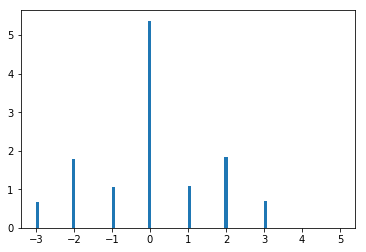

In [9]:
_ = plt.hist(y_target,100,density=True)

In [10]:
import scipy.sparse
X = scipy.sparse.dok_matrix((ROWS,n_players*2+2))
X._update(X_dict)
X = scipy.sparse.csr_matrix(X)

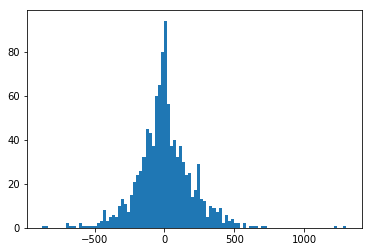

In [11]:
_ = plt.hist(np.array(X.sum(0))[0],100)

In [12]:
from sklearn import linear_model

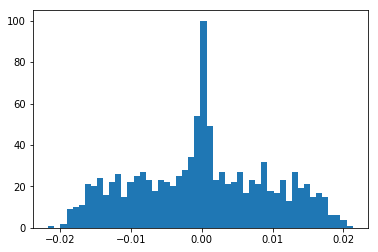

In [13]:
clf = linear_model.Ridge(alpha=300000,fit_intercept=False)
clf.fit(X,y_target)
_ = plt.hist(clf.coef_,50)


In [14]:
print(100*clf.coef_[-1],100*clf.coef_[-2])
t_score = 100*(clf.coef_[:clf.coef_.shape[0]//2-1] + clf.coef_[clf.coef_.shape[0]//2-1:-2])
v = np.argsort(t_score)[::-1]
for i in v:
    #try:
    name = players_list[i]
    #if 'Luka Doncic' not in name:
    #    continue
    #if name in ['LeBron James','Rudy Gobert','Stephen Curry','Kevin Knox','Tyson Chandler','James Harden']:
    print('{:60s} {:.2f} {:.2f}\t{:.2f}'.format(name,100*clf.coef_[i],100*clf.coef_[i+n_players],t_score[i]))

-0.40123246580935895 0.40974527936527344
Stephen Curry                                                1.77 -1.56	0.21
Kevin Durant                                                 2.03 -1.83	0.20
Giannis Antetokounmpo                                        1.74 -1.54	0.20
Danny Green                                                  1.61 -1.41	0.20
Pascal Siakam                                                1.80 -1.63	0.18
Eric Bledsoe                                                 1.67 -1.50	0.17
Brook Lopez                                                  1.70 -1.53	0.17
Khris Middleton                                              1.75 -1.58	0.16
Kyle Lowry                                                   1.60 -1.44	0.16
Damian Lillard                                               2.04 -1.88	0.15
Paul George                                                  2.00 -1.85	0.15
Draymond Green                                               1.52 -1.37	0.15
Jusuf Nurkic                       

In [15]:
og_players = [_ for _ in players_list if not '+' in _]
len(og_players)

530

In [16]:
on_value = {}
joint_value = {}
for i,n in enumerate(players_list):
    if '+' in n:
        names = n.split('+')
        for n2 in names:
            joint_value[n2] = joint_value.get(n2,0) + t_score[i] #(should be 4 of these!)
    else:
        on_value[n] = on_value.get(n,0) + t_score[i]

In [17]:

d_value = [(v-on_value[k],k) for k,v in joint_value.items()]
on_value = sorted([(v,k) for k,v in on_value.items()],reverse=True)
joint_value = sorted([(v,k) for k,v in joint_value.items()],reverse=True)
d_value = sorted(d_value,reverse=True)

In [18]:
for v,k in on_value:
    print('{:30s}\t{:.2f}'.format(k,v))

Stephen Curry                 	0.21
Kevin Durant                  	0.20
Giannis Antetokounmpo         	0.20
Danny Green                   	0.20
Pascal Siakam                 	0.18
Eric Bledsoe                  	0.17
Brook Lopez                   	0.17
Khris Middleton               	0.16
Kyle Lowry                    	0.16
Damian Lillard                	0.15
Paul George                   	0.15
Draymond Green                	0.15
Jusuf Nurkic                  	0.14
Malcolm Brogdon               	0.13
Joe Ingles                    	0.13
Al-Farouq Aminu               	0.12
Steven Adams                  	0.12
Rudy Gobert                   	0.12
Donovan Mitchell              	0.11
Jayson Tatum                  	0.11
Joel Embiid                   	0.11
James Harden                  	0.11
Klay Thompson                 	0.11
CJ McCollum                   	0.11
Kawhi Leonard                 	0.10
Paul Millsap                  	0.10
Eric Gordon                   	0.10
Fred VanVleet               

In [19]:
for v,k in joint_value:
    print('{:30s}\t{:.2f}'.format(k,v))

In [20]:
for v,k in d_value:
    print('{:30s}\t{:.2f}'.format(k,10*v))